In [2]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import random
from osgeo import gdal
import os
import seaborn as sns
from sklearn.metrics import roc_curve, auc, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
np.random.seed(42)

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


# **1. Xử lý gọn file Excel về vùng nghiên cứu**

In [ ]:
df = pd.read_excel('/content/drive/My Drive/Rainfall Data/Tablet/2019-t8-Bac-Trung-Bo.xlsx')

In [ ]:
df.head(3)

,Tên Trạm,Kinh độ,Vĩ độ,Xã,Huyện,Tỉnh,Loại dữ liệu,Thời Gian,Giá trị
0,Vạn Xuân,105.281389,19.832222,Vạn Xuân,Thường Xuân,Thanh Hóa,Rain10p,2019-08-01 00:00:00,0.0
1,Tân Kỳ,105.473611,19.108333,TT Tân Kỳ,Tân Kỳ,Nghệ An,Rain10p,2019-08-01 00:00:00,0.0
2,Vạn Xuân,105.281389,19.832222,Vạn Xuân,Thường Xuân,Thanh Hóa,Rain10p,2019-08-01 04:20:00,0.0


**matching time from Himawari-8 to Ha Tinh province: GMT+00 . GMT+07**

In [ ]:
pd.to_datetime(df['Thời Gian'])
df['Thời Gian'] = df['Thời Gian'].apply(lambda x: x - pd.Timedelta("0 days 7 hours"))
df['date'] = df['Thời Gian'].dt.date
df['time'] = df['Thời Gian'].dt.time

In [ ]:
df[df['Tỉnh'] == 'Hà Tĩnh'].sort_values(by=['date', 'time'])['Tên Trạm'].unique()

array(['Sơn Kim'], dtype=object)

In [ ]:
df.groupby(['date', 'Tỉnh'])['Giá trị'].sum().sort_values(ascending=False).head(20)

In [ ]:
df.loc[df['Tỉnh'].isin(['Hà Tĩnh'])].groupby(['date', 'Tỉnh'])['Giá trị'].sum().sort_values(ascending=False).head(20)

In [ ]:
df[df['Tỉnh'] == 'Hà Tĩnh'].sort_values(by=['date', 'time']).drop(columns=['Kinh độ', 'Vĩ độ', 'Thời Gian', 'Tên Trạm', 'Xã', 'Huyện', 'Tỉnh', 'Loại dữ liệu']).to_excel('/content/drive/My Drive/Rainfall Data/Tablet/2019-t8-Ha-Tinh.xlsx', index=False)

---

In [ ]:
df = pd.read_excel('/content/drive/My Drive/Rainfall Data/Tablet/2019-t8-Ha-Tinh.xlsx')

In [ ]:
pd.to_datetime(df['date'])
pd.to_datetime(df['time'])

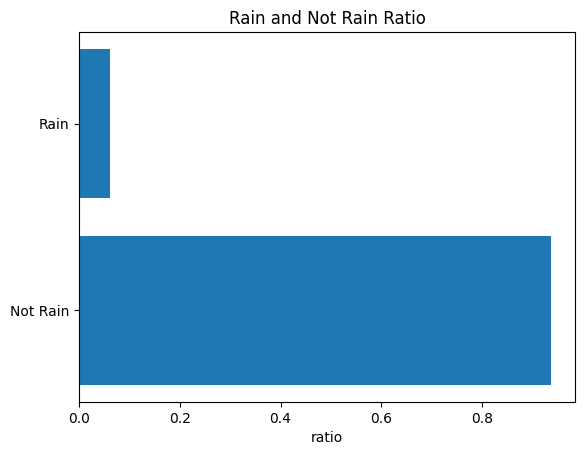

In [ ]:
stt = ['Rain', 'Not Rain']
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(stt))
not_rain_num = len(df[df['Giá trị'] == 0])
rain_num = len(df[df['Giá trị'] != 0])
ratio = np.array([rain_num / (not_rain_num + rain_num), not_rain_num / (not_rain_num + rain_num)])
ax.barh(y_pos, ratio, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(stt)
ax.invert_yaxis()
ax.set_xlabel('ratio')
ax.set_title('Rain and Not Rain Ratio')

plt.show()

In [ ]:
len(df[df['Giá trị'] != 0]['date'].dt.day.unique())

18

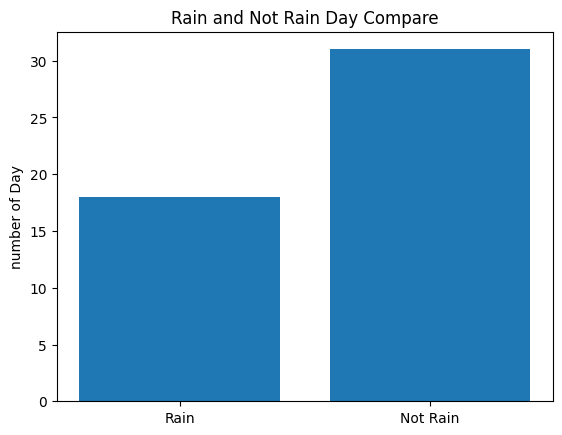

In [ ]:
plt.bar(['Rain', 'Not Rain'],\
        [len(df[df['Giá trị'] != 0]['date'].dt.day.unique()) ,\
         len(df[df['Giá trị'] == 0]['date'].dt.day.unique())],\
        align='center')
plt.ylabel('number of Day')
plt.title('Rain and Not Rain Day Compare')
plt.show()

*Dữ liệu mưa và không mưa đang ở tình trạng Unbalance và có tới 10 ngày không có một chút mưa nào*

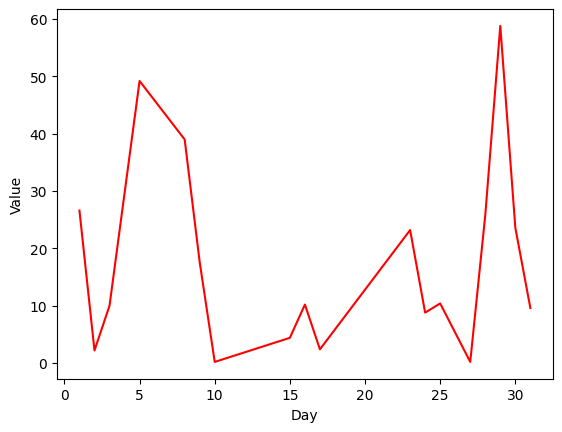

In [ ]:
# Các ngày có mưa và giá trị
plt.xlabel('Day')
plt.ylabel('Value')
plt.plot(df[(df['Giá trị'] != 0)& (df['date'].dt.month != 7)]['date'].dt.day.unique(),df[(df['Giá trị'] != 0)& (df['date'].dt.month != 7)].groupby(by=['date'])['Giá trị'].sum(), 'r')

In [ ]:
df.groupby(by=['date'])['Giá trị'].sum().describe().T

count    32.000000
mean     10.075000
std      15.492912
min       0.000000
25%       0.000000
50%       1.200000
75%      12.200000
max      58.800000
Name: Giá trị, dtype: float64

Note lại Kinh độ - Vĩ độ của 1 trạm duy nhất đo mưa tại Hà Tĩnh:

Kinh độ: 105.683222

Vĩ độ: 18.280556

# **2. Trích chọn đặc trưng**

**Lấy ra các tổ hợp đặc trưng**

tbb_08: $6.2\mu m$

tbb_09: $6.9 \mu m$

tbb_10: $7.3 \mu m$

tbb_11: $8.6 \mu m$

tbb_12: $9.6 \mu m$

tbb_13: $10.4 \mu m$

tbb_14: $11.2 \mu m$

tbb_15: $12.4 \mu m$

tbb_16: $13.3 \mu m$

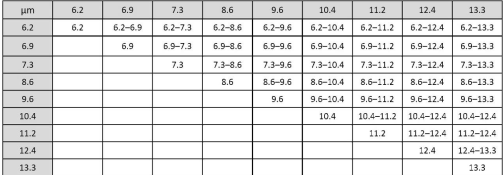

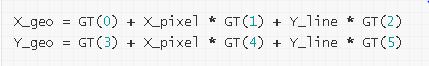

# **Convert Time về vùng nghiên cứu**

In [ ]:
m62, m69, m73, m86, m96, m104, m112, m124, m133 = [], [], [], [], [], [], [], [], []
m = [m62, m69, m73, m86, m96, m104, m112, m124, m133]
# Lấy ra các đặc trưng thuần
def org_feature():
  for i in range(len(df)):
    # get all bands
    for b in range(8, 17):
      band = 'tbb_' + str(b).rjust(2, '0')
      path = '/content/drive/My Drive/Rainfall Data/Tiff/' + band + '/' + str(df.iloc[i, 1].day).rjust(2, '0') + '/H08_' + band + '_201908' + str(df.iloc[i, 1].day).rjust(2, '0') + '_' + ''.join(df.iloc[i, 2].split(':')[:-1]) + '.tiff'

      # Nếu dòng dữ liệu ko có dữ liệu ảnh tương ứng thì ta fill np.nan vào đó
      if os.path.isfile(path) == False:
        m[b - 8].append(np.nan)
        continue
      
      ds = gdal.Open(path)
      if ds is None:
        m[b - 8].append(np.nan)
      else:
        ds_band = ds.GetRasterBand(1)
        gt = ds.GetGeoTransform()
        ds_arr = ds.ReadAsArray().astype(np.float64)
        # Chuyển đổi Kinh độ, Vĩ độ sang tọa độ trên raster map
        lat, lon = 18.280556, 105.683222
        offset_x = int((lat - gt[3])/gt[5])
        offset_y = int((lon - gt[0])/gt[1])
        # Lấy đặc trưng
        m[b - 8].append(ds_arr[offset_x, offset_y])

In [ ]:
org_feature()

In [ ]:
df['6.2'] = pd.Series(np.array(m62))
df['6.9'] = pd.Series(np.array(m69))
df['7.3'] = pd.Series(np.array(m73))
df['8.6'] = pd.Series(np.array(m86))
df['9.6'] = pd.Series(np.array(m96))
df['10.4'] = pd.Series(np.array(m104))
df['11.2'] = pd.Series(np.array(m112))
df['12.4'] = pd.Series(np.array(m124))
df['13.3'] = pd.Series(np.array(m133))
# m62, m69, m73, m86, m96, m104, m112, m124, m133

In [ ]:
# Trích chọn các đặc trưng delta bands
mband = ['6.2', '6.9', '7.3', '8.6', '9.6', '10.4', '11.2', '12.4', '13.3']
for i in range(1, len(mband)):
  for j in range(0, i):
    df[mband[j] + '-' + mband[i]] = df[mband[j]] - df[mband[i]]

In [ ]:
df.isna().sum()

Giá trị         0
date            0
time            0
6.2          1794
6.9          1796
7.3          1794
8.6          1794
9.6          1794
10.4         1794
11.2         1795
12.4         1796
13.3         1795
6.2-6.9      1796
6.2-7.3      1794
6.9-7.3      1796
6.2-8.6      1794
6.9-8.6      1796
7.3-8.6      1794
6.2-9.6      1794
6.9-9.6      1796
7.3-9.6      1794
8.6-9.6      1794
6.2-10.4     1794
6.9-10.4     1796
7.3-10.4     1794
8.6-10.4     1794
9.6-10.4     1794
6.2-11.2     1795
6.9-11.2     1797
7.3-11.2     1795
8.6-11.2     1795
9.6-11.2     1795
10.4-11.2    1795
6.2-12.4     1796
6.9-12.4     1798
7.3-12.4     1796
8.6-12.4     1796
9.6-12.4     1796
10.4-12.4    1796
11.2-12.4    1796
6.2-13.3     1795
6.9-13.3     1797
7.3-13.3     1795
8.6-13.3     1795
9.6-13.3     1795
10.4-13.3    1795
11.2-13.3    1795
12.4-13.3    1796
dtype: int64

In [ ]:
df.drop(columns=['date', 'time']).describe().T

,count,mean,std,min,25%,50%,75%,max
Giá trị,4359.0,0.073962,0.589084,0.0,0.00,0.0,0.00,16.8
6.2,2565.0,-4600.823782,876.797967,-8060.0,-5042.00,-4428.0,-3924.00,-3318.0
6.9,2563.0,-3944.423332,1148.320931,-8333.0,-4566.00,-3679.0,-3030.00,-2361.0
7.3,2565.0,-3363.729435,1395.641237,-8305.0,-4171.00,-3075.0,-2226.00,-1451.0
8.6,2565.0,-1764.158285,2328.567739,-8422.0,-3306.00,-1652.0,-8.00,2320.0
9.6,2565.0,-2810.416764,1424.331144,-6261.0,-3812.00,-2811.0,-1699.00,-167.0
10.4,2565.0,-1710.636257,2404.264900,-8387.0,-3346.00,-1606.0,118.00,2532.0
11.2,2564.0,-1962.052262,2413.347714,-8466.0,-3656.00,-1892.0,-173.00,2307.0
12.4,2563.0,-2259.240343,2296.331693,-8477.0,-3871.00,-2179.0,-523.00,1718.0
13.3,2564.0,-2937.822543,1881.964024,-8266.0,-4245.50,-2796.0,-1481.00,134.0


In [ ]:
df.drop(columns=['date', 'time']).dropna().describe().T

,count,mean,std,min,25%,50%,75%,max
Giá trị,2561.0,0.121046,0.743807,0.0,0.0,0.0,0.0,16.8
6.2,2561.0,-4601.183132,877.242056,-8060.0,-5042.0,-4428.0,-3924.0,-3318.0
6.9,2561.0,-3944.632175,1148.571216,-8333.0,-4566.0,-3679.0,-3030.0,-2361.0
7.3,2561.0,-3364.479500,1396.224850,-8305.0,-4171.0,-3075.0,-2226.0,-1451.0
8.6,2561.0,-1765.379539,2329.258737,-8422.0,-3306.0,-1652.0,-8.0,2320.0
9.6,2561.0,-2811.210074,1424.700837,-6261.0,-3812.0,-2811.0,-1699.0,-167.0
10.4,2561.0,-1711.930105,2404.903596,-8387.0,-3351.0,-1606.0,114.0,2532.0
11.2,2561.0,-1963.965248,2413.663800,-8466.0,-3656.0,-1892.0,-174.0,2307.0
12.4,2561.0,-2259.912144,2296.870588,-8477.0,-3871.0,-2179.0,-525.0,1718.0
13.3,2561.0,-2939.310816,1882.161580,-8266.0,-4253.0,-2805.0,-1483.0,134.0


In [ ]:
df.head(5)

,Giá trị,6.2,6.9,7.3,8.6,9.6,10.4,11.2,12.4,13.3,...,10.4-12.4,11.2-12.4,6.2-13.3,6.9-13.3,7.3-13.3,8.6-13.3,9.6-13.3,10.4-13.3,11.2-13.3,12.4-13.3
0,0.0,0.422068,0.494304,0.511822,0.211001,0.193208,0.242856,0.228314,0.239029,0.323261,...,0.132163,0.012065,-0.221181,-0.049157,0.180227,-0.196988,-0.577859,-0.038944,-0.097507,-0.134605
1,0.0,0.355938,0.427251,0.399354,0.046539,-0.010383,0.052374,0.054685,0.081828,0.184564,...,-0.233930,-0.328766,-0.032628,0.173192,0.356773,-0.402515,-0.628167,-0.353617,-0.366160,-0.361217
2,0.0,0.334275,0.415930,0.406518,0.098497,0.044376,0.108936,0.096124,0.110133,0.198912,...,0.034035,-0.123092,-0.075354,0.124856,0.327915,-0.244158,-0.539693,-0.179508,-0.242036,-0.275105
3,0.0,0.377601,0.471662,0.556236,0.603048,0.656554,0.640870,0.576815,0.533836,0.568240,...,1.188928,0.975795,-0.685599,-0.637657,-0.497098,0.564473,-0.232636,0.753329,0.548622,0.354878
4,0.0,0.197456,0.325365,0.445917,0.496126,0.528783,0.494890,0.456642,0.424971,0.426886,...,0.807738,0.740739,-0.585285,-0.519232,-0.306972,0.593112,-0.086914,0.617556,0.507814,0.391136


In [ ]:
df.drop(columns=['date', 'time']).dropna().to_csv('/content/drive/My Drive/Rainfall Data/Tablet/Dataset.csv', index = False)

In [4]:
df = pd.read_csv('/content/drive/My Drive/Rainfall Data/Tablet/Dataset.csv')
df.head(5)

,Giá trị,6.2,6.9,7.3,8.6,9.6,10.4,11.2,12.4,13.3,...,10.4-12.4,11.2-12.4,6.2-13.3,6.9-13.3,7.3-13.3,8.6-13.3,9.6-13.3,10.4-13.3,11.2-13.3,12.4-13.3
0,0.0,-4231.0,-3377.0,-2650.0,-1274.0,-2536.0,-1128.0,-1413.0,-1711.0,-2331.0,...,583.0,298.0,-1900.0,-1046.0,-319.0,1057.0,-205.0,1203.0,918.0,620.0
1,0.0,-4289.0,-3454.0,-2807.0,-1657.0,-2826.0,-1586.0,-1832.0,-2072.0,-2592.0,...,486.0,240.0,-1697.0,-862.0,-215.0,935.0,-234.0,1006.0,760.0,520.0
2,0.0,-4308.0,-3467.0,-2797.0,-1536.0,-2748.0,-1450.0,-1732.0,-2007.0,-2565.0,...,557.0,275.0,-1743.0,-902.0,-232.0,1029.0,-183.0,1115.0,833.0,558.0
3,0.0,-4270.0,-3403.0,-2588.0,-361.0,-1876.0,-171.0,-572.0,-1034.0,-1870.0,...,863.0,462.0,-2400.0,-1533.0,-718.0,1509.0,-6.0,1699.0,1298.0,836.0
4,0.0,-4428.0,-3571.0,-2742.0,-610.0,-2058.0,-522.0,-862.0,-1284.0,-2136.0,...,762.0,422.0,-2292.0,-1435.0,-606.0,1526.0,78.0,1614.0,1274.0,852.0


In [ ]:
from sklearn.preprocessing import StandardScaler
stdtf = StandardScaler()
df[df.drop(columns=['Giá trị']).columns] = stdtf.fit_transform(df[df.drop(columns=['Giá trị']).columns])

In [ ]:
df.head(2)

,Giá trị,6.2,6.9,7.3,8.6,9.6,10.4,11.2,12.4,13.3,...,10.4-12.4,11.2-12.4,6.2-13.3,6.9-13.3,7.3-13.3,8.6-13.3,9.6-13.3,10.4-13.3,11.2-13.3,12.4-13.3
0,0.0,0.422068,0.494304,0.511822,0.211001,0.193208,0.242856,0.228314,0.239029,0.323261,...,0.132163,0.012065,-0.221181,-0.049157,0.180227,-0.196988,-0.577859,-0.038944,-0.097507,-0.134605
1,0.0,0.355938,0.427251,0.399354,0.046539,-0.010383,0.052374,0.054685,0.081828,0.184564,...,-0.233930,-0.328766,-0.032628,0.173192,0.356773,-0.402515,-0.628167,-0.353617,-0.366160,-0.361217


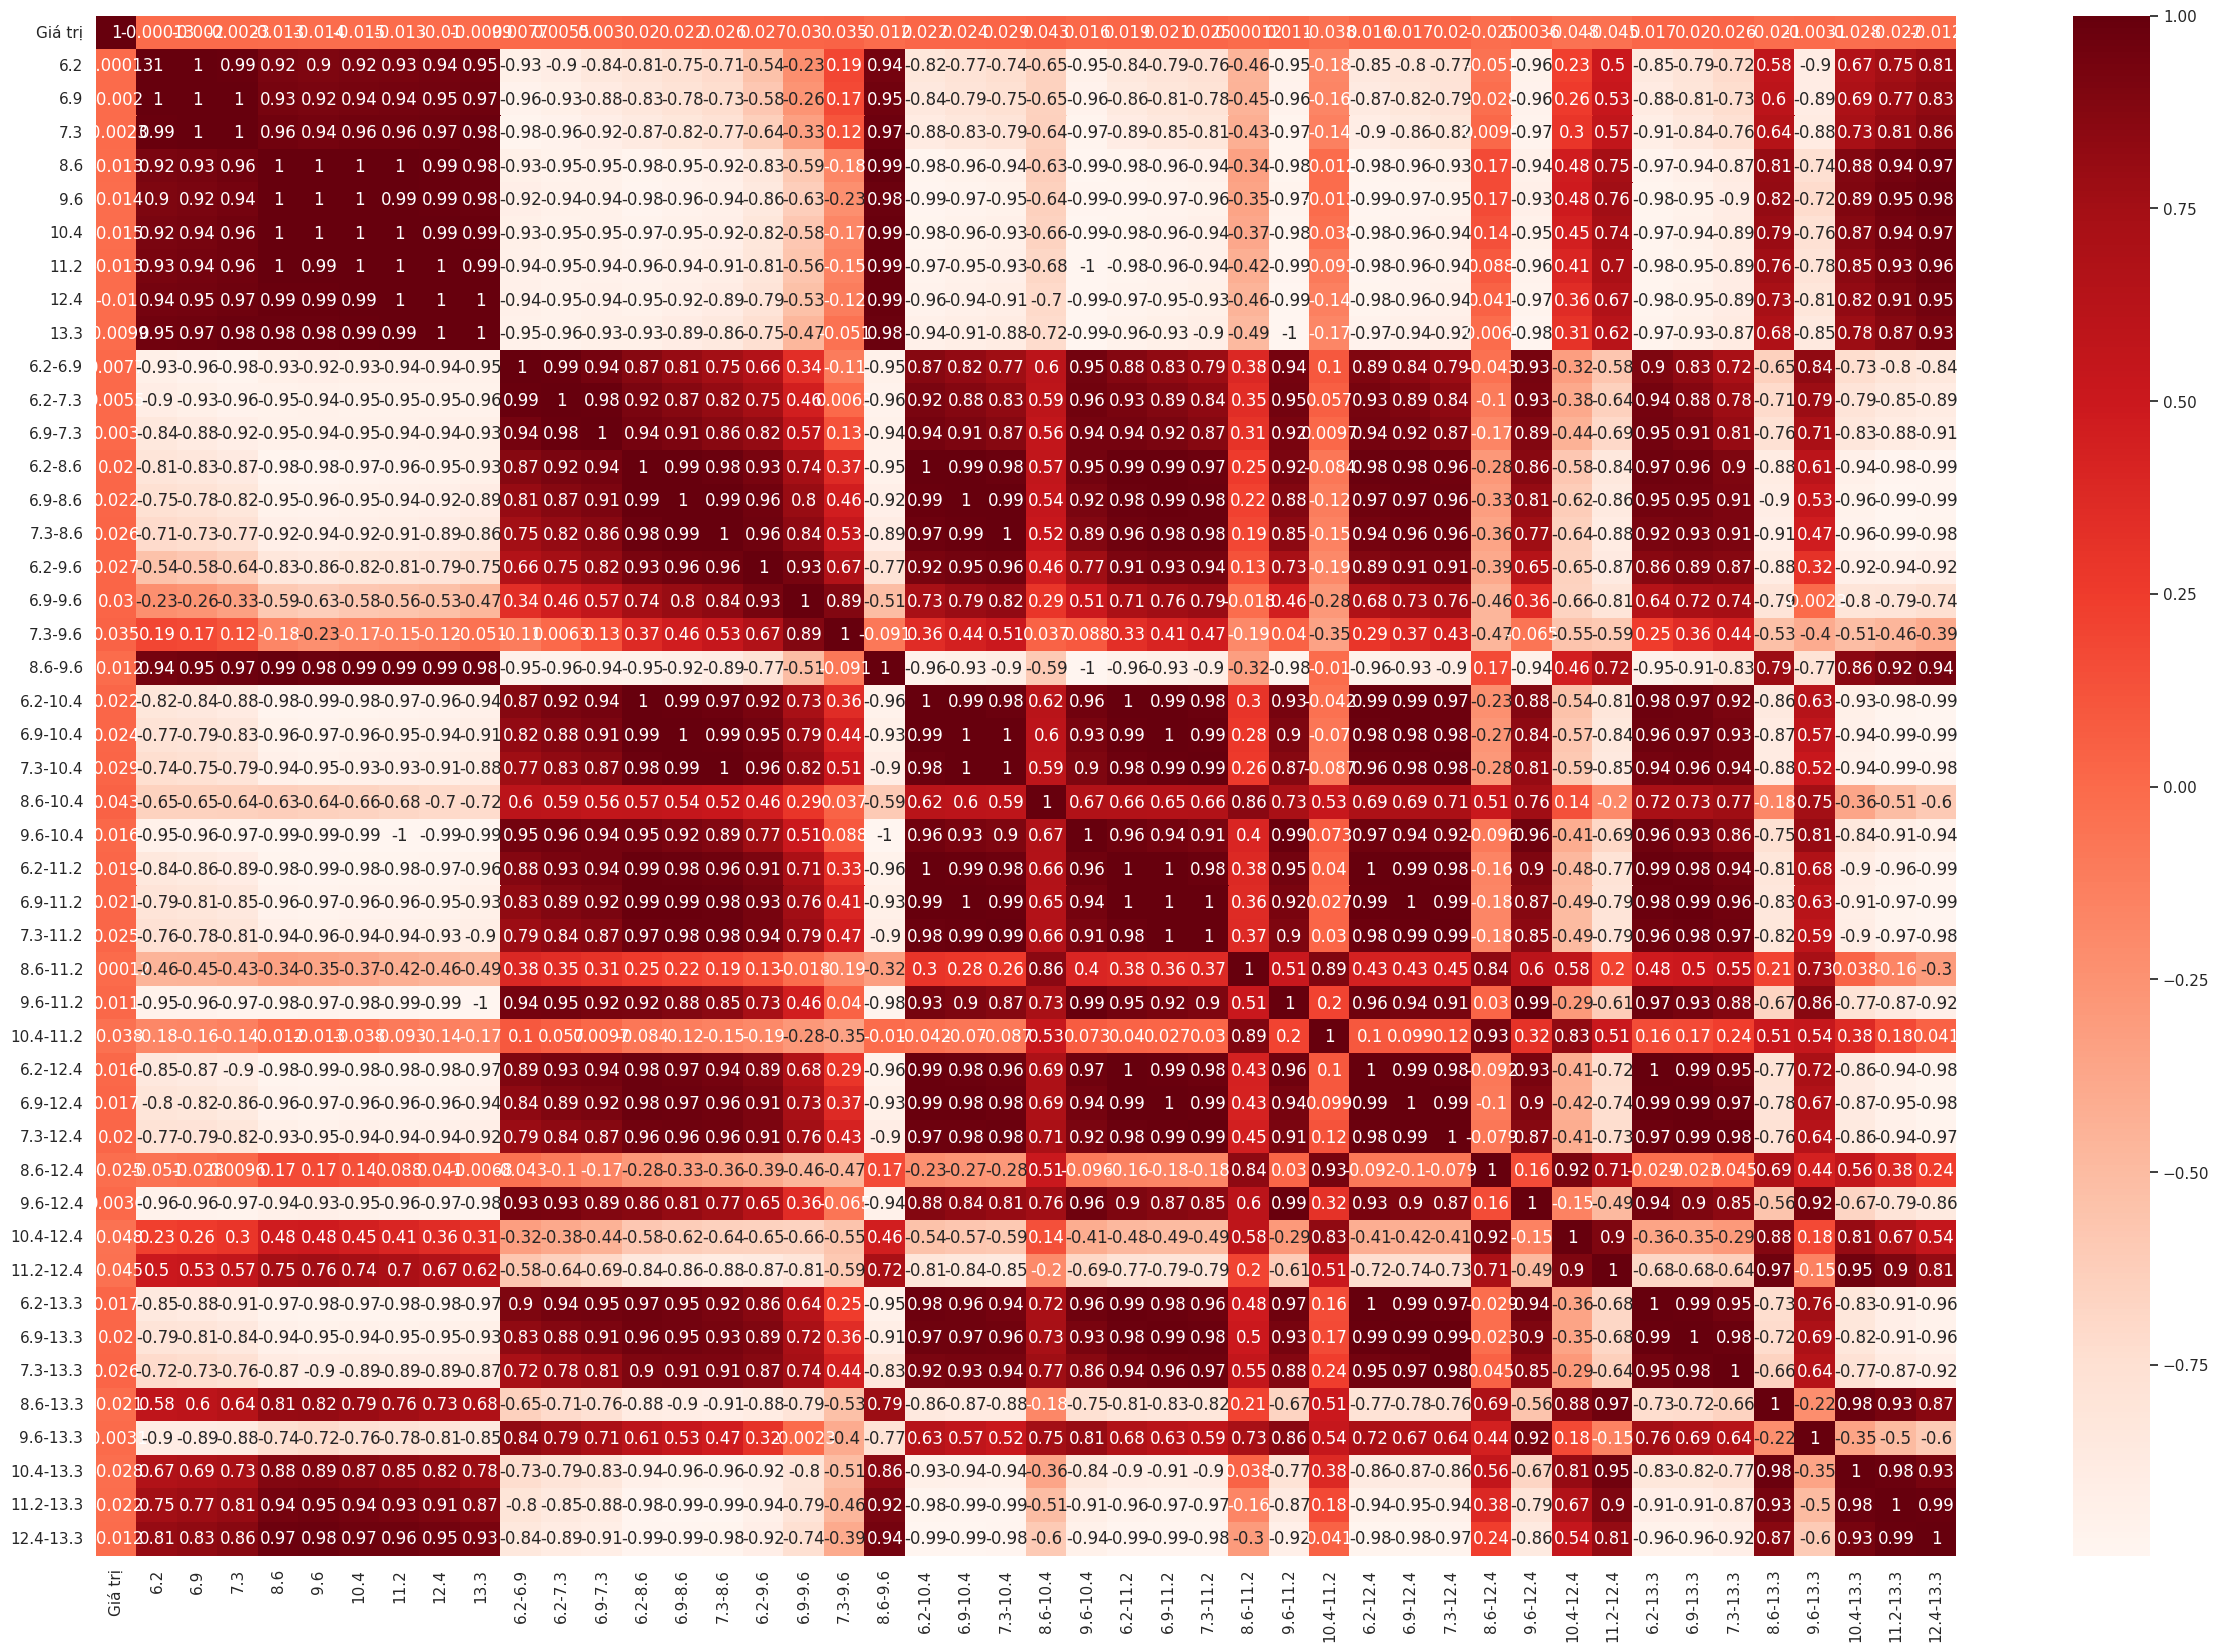

In [ ]:
sns.set(rc = {'figure.figsize':(30,20)})
df_hm = sns.heatmap(df.corr(), cmap="Reds", annot=True)
plt.show()

**Thử chạy RF regression với dataset gồm các features:**

$BT10.4$

$\Delta T7.3-13.3$

$\Delta T8.6-10.4$

$\Delta T10.4-12.4$

$\Delta T6.2-6.9$

$\Delta T6.9-7.3$

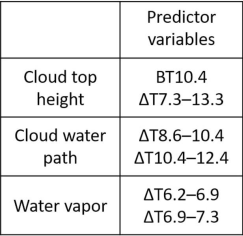

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier

**Block Randomforest có nhiệm vụ phát hiện mưa hay không mưa**

In [5]:
X_ronr = df[['10.4', '7.3-13.3', '8.6-10.4', '10.4-12.4', '6.2-6.9', '6.9-7.3']]
y_ronr = (df['Giá trị'] > 0.0).astype(int)

In [7]:
len(y_ronr)

2561

In [6]:
len([x for x in range(len(y_ronr)) if y_ronr[x] == 1])

258

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_ronr, y_ronr, test_size=0.33, random_state=42)

In [ ]:
rf_cls = RandomForestClassifier(random_state=42, verbose=1)

In [ ]:
rf_cls.fit(X_train1, y_train1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


RandomForestClassifier(random_state=42, verbose=1)

In [ ]:
roc_auc_score(y_test1, rf_cls.predict_proba(X_test1)[:, 1])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


0.7396668002136753

In [ ]:
print(classification_report(y_pred=rf_cls.predict(X_test1), y_true=y_test1))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       768
           1       0.25      0.04      0.07        78

    accuracy                           0.90       846
   macro avg       0.58      0.51      0.51       846
weighted avg       0.85      0.90      0.87       846



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


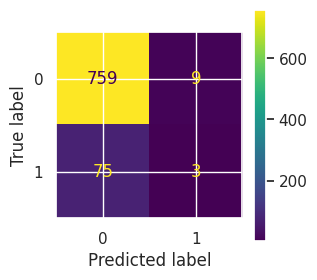

In [ ]:
sns.set(rc = {'figure.figsize':(3,3)})
cm = confusion_matrix(y_test1, rf_cls.predict(X_test1), labels=np.array([0, 1]))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(['0', '1']))
disp.plot()
plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


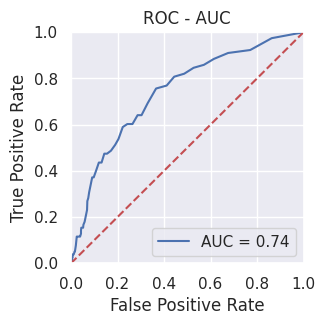

In [ ]:
fpr, tpr, threshold = roc_curve(y_test1, rf_cls.predict_proba(X_test1)[:, 1])
roc_auc = auc(fpr, tpr)
plt.title('ROC - AUC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

---

**Block Randomforest có nhiệm vụ dự đoán lượng mưa tại những điểm có mưa**

In [ ]:
X_est = df[rf_cls.predict(X_ronr) == 1][['10.4', '7.3-13.3', '8.6-10.4', '10.4-12.4', '6.2-6.9', '6.9-7.3']]
y_est = df[rf_cls.predict(X_ronr) == 1]['Giá trị']

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_est, y_est, test_size=0.33, random_state=42)

In [ ]:
RFr = RandomForestRegressor(random_state=42)
RFr.fit(X_train2, y_train2)

RandomForestRegressor(random_state=42)

In [ ]:
print('MSE train: %.2f' % mean_squared_error(y_train2, RFr.predict(X_train2)))
print('MSE test: %.2f' % mean_squared_error(y_test2, RFr.predict(X_test2)))

MSE train: 0.56
MSE test: 2.51


In [ ]:
sns.set(rc = {'figure.figsize':(6,6)})

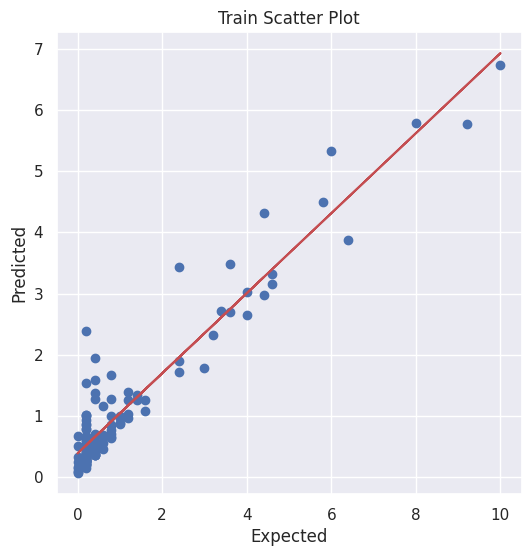

In [ ]:
plt.ylabel('Predicted')
plt.xlabel('Expected')
plt.title('Train Scatter Plot')
plt.plot(y_train2, RFr.predict(X_train2), 'o')
m, b = np.polyfit(y_train2, RFr.predict(X_train2), 1)
plt.plot(y_train2, m*y_train2 + b, 'r')
plt.show()

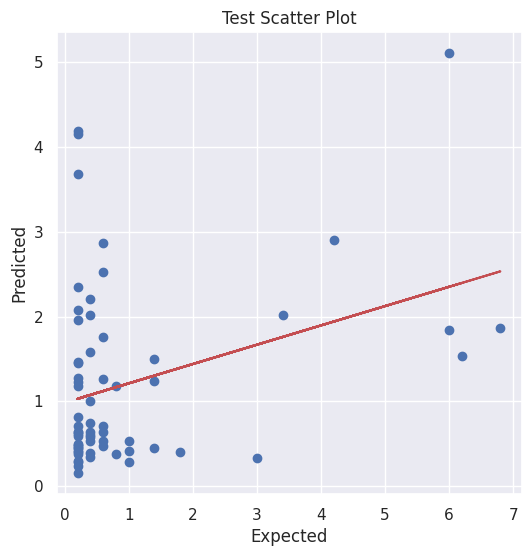

In [ ]:
plt.ylabel('Predicted')
plt.xlabel('Expected')
plt.title('Test Scatter Plot')
plt.plot(y_test2, RFr.predict(X_test2), 'o')
m, b = np.polyfit(y_test2, RFr.predict(X_test2), 1)
plt.plot(y_test2, m*y_test2 + b, 'r')
plt.show()

*Mô hình đang bị Overfitting*

**Chạy XGBoost với cùng bộ dataset**

In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBRegressor
from xgboost import XGBClassifier

*Dự đoán mưa - không mưa*

In [ ]:
XGBc = XGBClassifier(eval_metric='auc')

In [ ]:
XGBc.fit(X_train1, y_train1)

XGBClassifier(eval_metric='auc')

In [ ]:
roc_auc_score(y_test1, XGBc.predict_proba(X_test1)[:, 1])

0.7132161458333334

In [ ]:
print(classification_report(y_pred=XGBc.predict(X_test1), y_true=y_test1))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       768
           1       0.25      0.01      0.02        78

    accuracy                           0.91       846
   macro avg       0.58      0.50      0.49       846
weighted avg       0.85      0.91      0.86       846



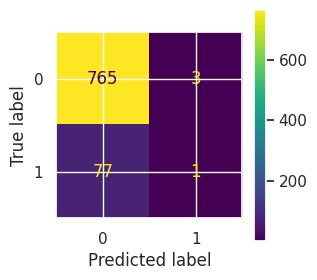

In [ ]:
sns.set(rc = {'figure.figsize':(3,3)})
cm = confusion_matrix(y_test1, XGBc.predict(X_test1), labels=np.array([0, 1]))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(['0', '1']))
disp.plot()
plt.show()

In [ ]:
sns.set(rc = {'figure.figsize':(6,6)})

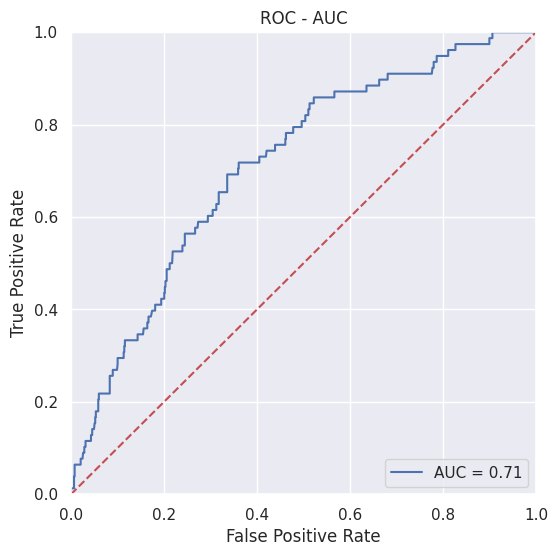

In [ ]:
fpr, tpr, threshold = roc_curve(y_test1, XGBc.predict_proba(X_test1)[:, 1])
roc_auc = auc(fpr, tpr)
plt.title('ROC - AUC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

*Ước lượng mưa*

In [ ]:
XGBr = XGBRegressor(n_estimators=100,max_depth=2)
XGBr.fit(X_train2, y_train2)

[21:33:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(max_depth=2)

In [ ]:
print('MSE train: %.2f' % mean_squared_error(y_train2, XGBr.predict(X_train2)))
print('MSE test: %.2f' % mean_squared_error(y_test2, XGBr.predict(X_test2)))

MSE train: 0.67
MSE test: 2.23


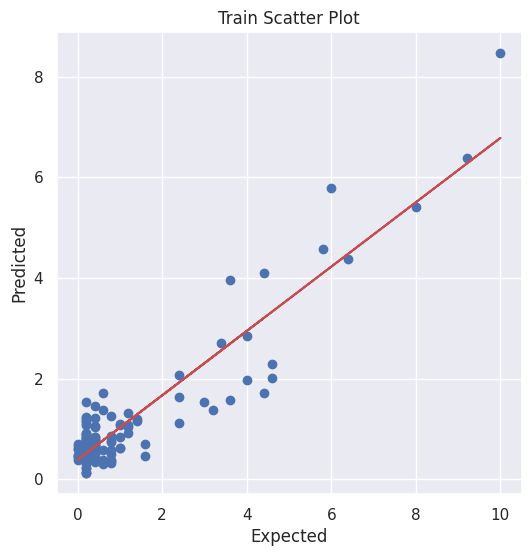

In [ ]:
plt.ylabel('Predicted')
plt.xlabel('Expected')
plt.title('Train Scatter Plot')
plt.plot(y_train2, XGBr.predict(X_train2), 'o')
m, b = np.polyfit(y_train2, XGBr.predict(X_train2), 1)
plt.plot(y_train2, m*y_train2 + b, 'r')
plt.show()

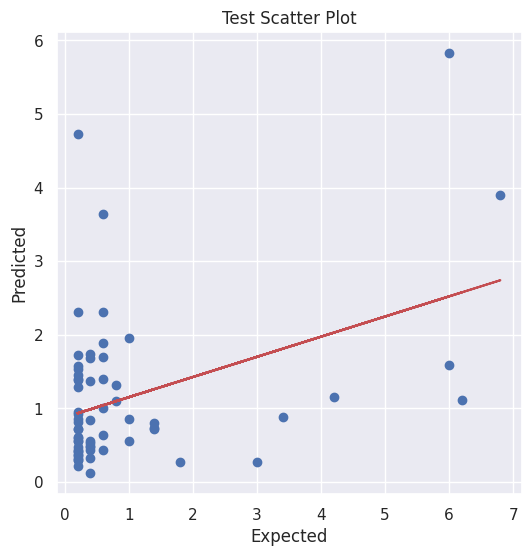

In [ ]:
plt.ylabel('Predicted')
plt.xlabel('Expected')
plt.title('Test Scatter Plot')
plt.plot(y_test2, XGBr.predict(X_test2), 'o')
m, b = np.polyfit(y_test2, XGBr.predict(X_test2), 1)
plt.plot(y_test2, m*y_test2 + b, 'r')
plt.show()